In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


<a id="1"></a> <br>
# 1. Import Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from tensorflow import keras
from keras import models
from keras import layers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a> <br>
# 2. Import Dataset

In [3]:
# Import Train&test Dataset
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_data = pd.concat([df_train,df_test]).reset_index(drop=True)
df_data = df_data.set_index('PassengerId')

In [4]:
df_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<a id="1"></a> <br>
# 3. Missing Values

In [5]:
df_data.isnull().iloc[:,1:].sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

<AxesSubplot:>

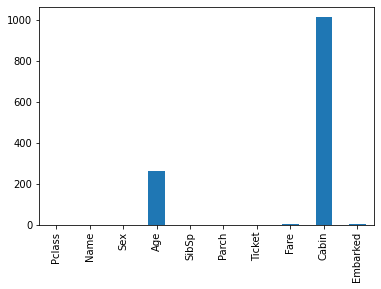

In [6]:
df_data.isnull().iloc[:,1:].sum().plot(kind='bar')

<AxesSubplot:xlabel='Survived', ylabel='count'>

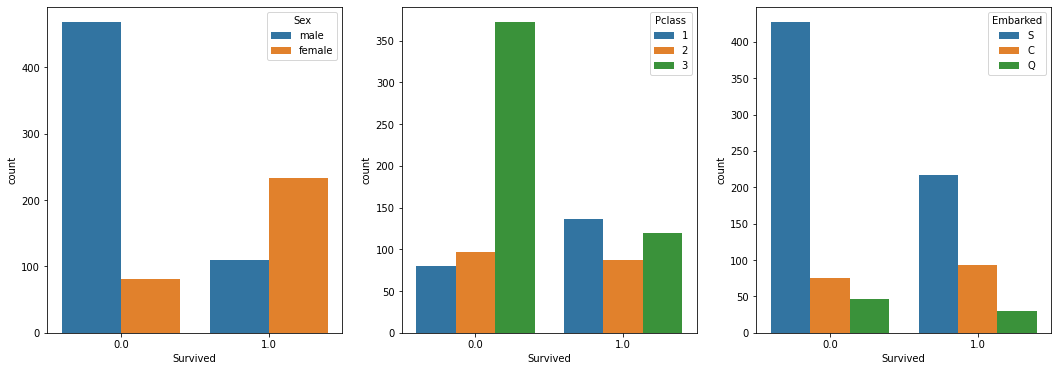

In [7]:
fig , axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
sns.countplot(x = 'Survived', hue = 'Sex', data= df_data, ax = axes[0])
sns.countplot(x = 'Survived', hue = 'Pclass', data= df_data, ax = axes[1])
sns.countplot(x = 'Survived', hue = 'Embarked', data= df_data, ax = axes[2])

<AxesSubplot:>

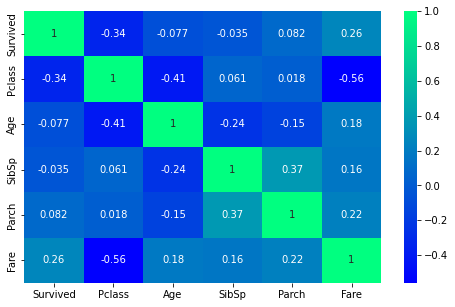

In [8]:
#Corralation
plt.figure(figsize=(8,5))
sns.heatmap(df_data.corr(),annot=True, cmap='winter')

In [9]:
df_Age_corr  = pd.DataFrame(df_data.corr().Age.abs())

In [10]:
df_Age_corr

,Age
Survived,0.077221
Pclass,0.408106
Age,1.000000
SibSp,0.243699
Parch,0.150917
Fare,0.178740


Since PClass is the variable that is most correlated with both Age and Survived, we will group passengers according to the class they belong to. What we will do is replace the missing values with the median of each group.

In [11]:
df_data.Age = df_data.groupby(['Pclass','Sex'])['Age'].apply(lambda x:x.fillna(x.median()))
print('Number of Missing Value for Age is : {}'.format(df_data.Age.isnull().sum()))

Number of Missing Value for Age is : 0


For Embarked, we will replace the missing values by the mode, i.e. the most repeated value.

In [12]:
df_data.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [13]:
df_data.Embarked.replace(np.nan, 'S', inplace=True)
print('Number of Missing Value for Embarked is : {}'.format(df_data.Embarked.isnull().sum()))

Number of Missing Value for Embarked is : 0


We have one missing value for Fare, belonging to one male of the testing dataset. We can assume that it is related to FamilySize and PClass. Median Fare value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [14]:
df_data[df_data.Fare.isnull()==True]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [15]:
median_Fare = df_data.groupby(['Pclass','Parch','SibSp']).Fare.median()[3][0][0]
df_data.Fare = df_data.Fare.fillna(median_Fare)
print('Number of Missing Value for Fare is : {}'.format(df_data.Fare.isnull().sum()))

Number of Missing Value for Fare is : 0


In [16]:
# Remove Cabin Columns
df_data.drop('Cabin', axis=1, inplace=True)

Now, we don't have any Missing Data

In [17]:
df_data.isnull().iloc[:,1:].sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

<a id="1"></a> <br>
# 4. Feature Engineering

We will start by creating fields related to the family unit. The first of these will come from the SibSp and Parch fields, which we can remove later. This will reflect the size of passengers' family. We will also enter a field to indicate whether the passenger is travelling alone or not.

In [18]:
df_data['FamilySize'] = df_data['Parch'] + df_data['SibSp'] + 1
df_data['Alone'] = 0
df_data['Alone'] = df_data['FamilySize'].apply(lambda x: 0 if x>1 else 1)
df_data.drop(['Parch','SibSp'],axis=1,inplace=True)

<AxesSubplot:xlabel='Survived', ylabel='count'>

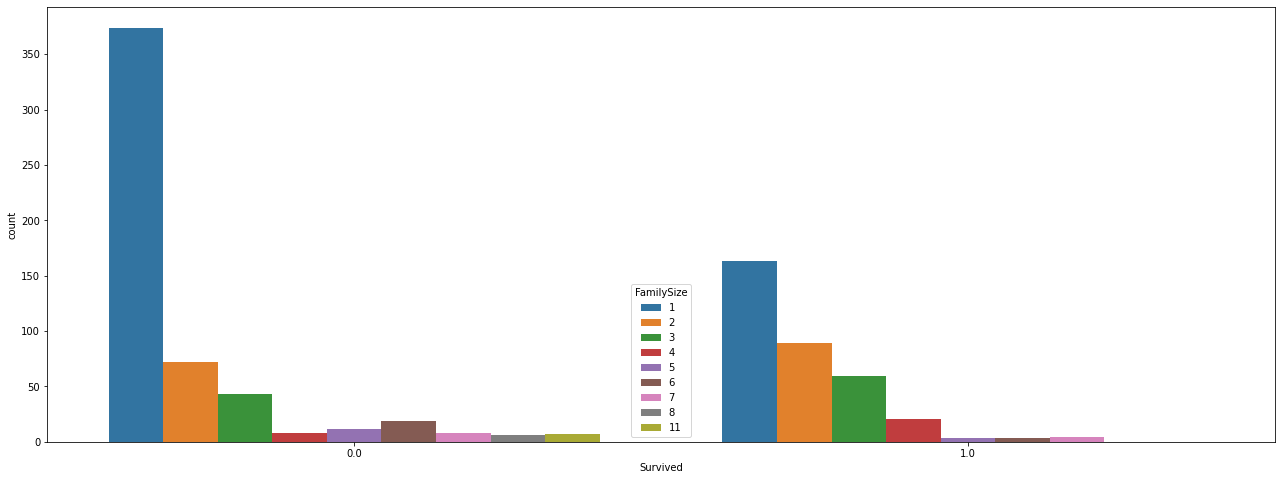

In [19]:
fig, axes = plt.subplots(figsize=(22,8))
sns.countplot(x ='Survived',hue='FamilySize', data=df_data)

I have decided to group Family Size into 4 different groups:

Alone: for people travelling with no member of his/her family.

Small: for people travelling with 3 members of family

Medium: travelling with 4 or 5 members of family

Large: travelling with 6+ members of family


In [20]:
family_group = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_data['FamilyGroup'] = df_data.FamilySize.map(family_group)

<AxesSubplot:xlabel='Survived', ylabel='count'>

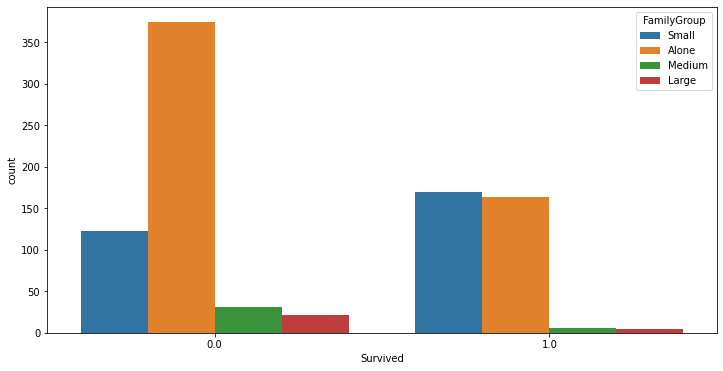

In [21]:
fig, axes = plt.subplots(figsize=(12,6))
sns.countplot(x ='Survived',hue='FamilyGroup', data=df_data)

Based on the chart above ,we can observe that lonely people tend to die. On the other hand, small families members are most likely to survive.

Now we are going to add a column that will be related to the Name field:

In [22]:
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(df_data['Title'], df_data['Sex']).transpose()

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [23]:
df_data['Title'] = df_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df_data['Title'] = df_data['Title'].replace('Mlle', 'Miss')
df_data['Title'] = df_data['Title'].replace('Ms', 'Miss')
df_data['Title'] = df_data['Title'].replace('Mme', 'Mrs')
pd.crosstab(df_data['Title'], df_data['Sex']).transpose()

Title,Master,Miss,Mr,Mrs,Rare
Sex,,,,,
female,0,264,0,198,4
male,61,0,757,0,25


In order to binning continuous features we are going to use 13 quantile base bins for Fare column and 10 bins for Age column:

In [24]:
names = ['1', '2', '3', '4', '5', '6', '7','8','9','10','11','12','13']
df_data.Fare = pd.qcut(df_data.Fare, 13 , labels=names)
df_data.Fare = pd.to_numeric(df_data.Fare)

In [25]:
names = ['1','2','3','4','5','6','7','8','9','10']
df_data['Age'] = pd.qcut(df_data['Age'], 10, labels = names)

In [26]:
Remove_List = ['Name','Ticket']
df_data.drop(Remove_List, axis=1, inplace=True)

<a id="1"></a> <br>
# 5. Feature Transformation

Using LabelEncoder, we are going to convert non-numerical features to numerical type. LabelEncoder basically labels the classes from 0 to n. This process is necessary for models to learn from those features.

In [27]:
n_col  = [col for col in df_data.columns if df_data[col].dtype=='object']
n_col.append('Age')
for col in n_col:
  df_data[col] = LabelEncoder().fit_transform(df_data[col])

To finish with, we are going to one hot encoded non-ordinal features. Those features are Embarked, Title, FamilyGroup and PClass. Age and Fare as ordinal features are not converted.

In [28]:
cat_features = ['Embarked', 'Pclass', 'Title', 'FamilyGroup']
for col in cat_features:
  one_hot = pd.get_dummies(df_data[col], prefix = col)
  df_data = pd.merge(left = df_data, right = one_hot, left_index=True,right_index=True)

In [29]:
df_data.drop(columns=['Embarked','Pclass','Title','FamilyGroup'],inplace=True)

In [30]:
df_data.head(5)

,Survived,Sex,Age,Fare,FamilySize,Alone,Embarked_0,Embarked_1,Embarked_2,Pclass_1,...,Pclass_3,Title_0,Title_1,Title_2,Title_3,Title_4,FamilyGroup_0,FamilyGroup_1,FamilyGroup_2,FamilyGroup_3
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1,3,1,2,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
2,1.0,0,8,12,2,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
3,1.0,0,5,4,1,1,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0
4,1.0,0,8,11,2,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
5,0.0,1,8,4,1,1,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0


<a id="1"></a> <br>
# 6. Modeling


In [31]:
# ٍExtract Train and Test Data from df_data
df_train = df_data[df_data.Survived.isnull()==False]
df_test = df_data[df_data.Survived.isnull()==True]
df_test= df_test.drop('Survived',axis=1)

In [32]:
df_train.Survived = df_train.Survived.astype('int')	

In [33]:
X = df_train.drop('Survived',axis=1)
y = df_train.Survived

**Using Keras to Build and Train Neural Networks**

In [34]:
# Split the data to Train, and Test (75%, 25%)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=42)

Get a baseline performance using Random Forest

To begin, and get a baseline for classifier performance:

    Train a Random Forest model with 200 trees on the training data.
    Calculate the accuracy and roc_auc_score of the predictions.



In [35]:
## Train the RF Model
RF = RandomForestClassifier(n_estimators=200)
RF.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200)

In [36]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred = RF.predict(X_test)
y_pred_proba = RF.predict_proba(X_test)

In [37]:
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_proba[:,1])))

accuracy is 0.825
roc-auc is 0.868


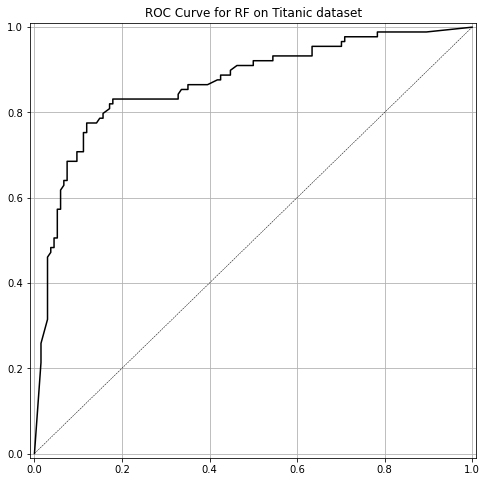

In [38]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on Titanic dataset'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_proba[:, 1], 'RF')
### END SOLUTION

**Build a Single Hidden Layer Neural Network**

In [39]:
## First let's normalize the data
SC = StandardScaler()
X_train_norm = SC.fit_transform(X_train)
X_test_norm = SC.transform(X_test) 

In [40]:
# Define the Model 
# Input size is 20-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)
model_1 = models.Sequential()
model_1.add(layers.Dense(12, activation='sigmoid', input_shape=(20,)))
model_1.add(layers.Dense(1, activation='sigmoid'))

2022-06-30 09:47:35.717981: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [41]:
#  This is a nice tool to view the model you have created and count the parameters
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                252       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
model_1.compile(SGD(lr = 0.003), loss = 'binary_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(X_train_norm,y_train, validation_data = (X_test_norm,y_test), epochs=200)

2022-06-30 09:47:36.022363: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
21/21 [==============================] - 1s 13ms/step - loss: 0.6573 - accuracy: 0.6512 - val_loss: 0.6341 - val_accuracy: 0.7265
Epoch 2/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6737 - val_loss: 0.6297 - val_accuracy: 0.7399
Epoch 3/200
21/21 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6781 - val_loss: 0.6257 - val_accuracy: 0.7130
Epoch 4/200
21/21 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6946 - val_loss: 0.6221 - val_accuracy: 0.7130
Epoch 5/200
21/21 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.7141 - val_loss: 0.6187 - val_accuracy: 0.7220
Epoch 6/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.7126 - val_loss: 0.6156 - val_accuracy: 0.7399
Epoch 7/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.7096 - val_loss: 0.6127 - val_accuracy: 0.7309
Epoch 8/200


In [43]:
y_pred = (model_1.predict(X_test_norm) > 0.5).astype("int32")
y_pred_proba = model_1.predict(X_test_norm)

In [44]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_proba)))

accuracy is 0.785
roc-auc is 0.873


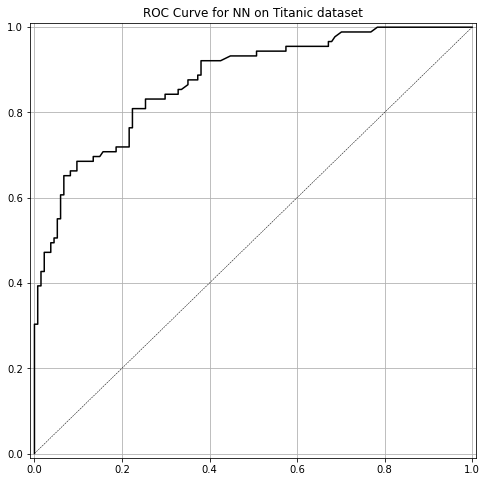

In [45]:
plot_roc(y_test, y_pred_proba, 'NN')

In [46]:
history_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

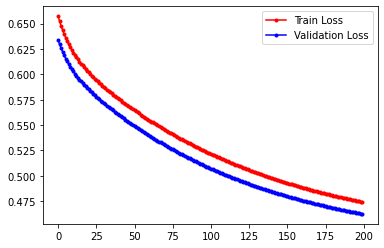

In [47]:
fig, ax = plt.subplots()
ax.plot(history_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(history_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set. This suggests that the model might benefit from further training. Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [48]:
history_2 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000,verbose=0)

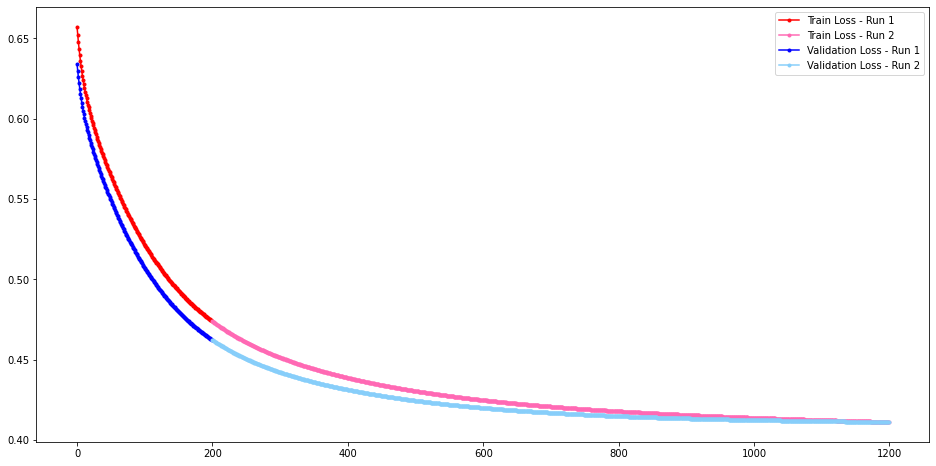

In [49]:
n = len(history_1.history["loss"])
m = len(history_2.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), history_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), history_2.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), history_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), history_2.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off. While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!). This suggests that our network will not benefit from further training. What is the appropriate number of epochs?

For this exercise, do the following in the cells below:

Build a model with two hidden layers, each with 6 nodes

Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer

Use a learning rate of .003 and train for 1500 epochs

Graph the trajectory of the loss functions, accuracy on both train and test set Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures


In [50]:
### BEGIN SOLUTION
model_2 = models.Sequential()
model_2.add(layers.Dense(6, input_shape=(20,), activation="relu"))
model_2.add(layers.Dense(6, activation="relu"))
model_2.add(layers.Dense(1, activation="sigmoid"))

model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
history_3 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500,verbose=0)

In [51]:
history_3.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy over iterations')

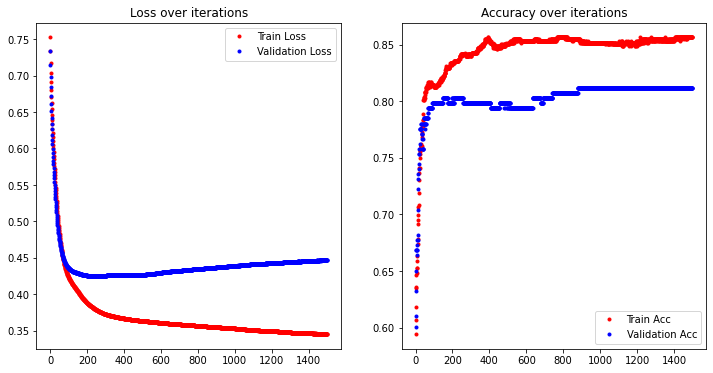

In [52]:
n = len(history_3.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (history_3.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (history_3.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (history_3.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (history_3.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

In [53]:
y_pred = (model_2.predict(X_test_norm) > 0.5).astype("int32")
y_pred_proba = model_2.predict(X_test_norm)

In [54]:
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_proba)))

accuracy is 0.812
roc-auc is 0.893


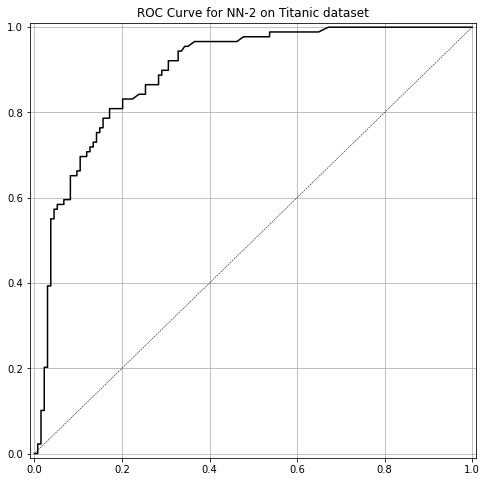

In [55]:
plot_roc(y_test, y_pred_proba, 'NN-2')

In [56]:
y_pred_test = (model_2.predict(df_test) > 0.5).astype("int32")

In [57]:
y_pred_test_t = np.reshape(y_pred_test,418)

In [58]:
df_gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [59]:
# Sample Submission
output = pd.DataFrame({'PassengerId': df_gender_submission.PassengerId, 'Survived': y_pred_test_t})
output.to_csv("submission.csv", index = False)